In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from tensorflow.keras.layers import Dense, GRU, Input
import pickle
import matplotlib.pyplot as plt

In [2]:
with open("../novelTrackReco/novelTrackRecoCylindricalData.pkl", "rb") as fp:
    X = pickle.load(fp)
    Y = pickle.load(fp)

X = X.astype(np.float32)
Y = Y.astype(np.float32)
#normalize data
# xNorm = 1068
# yNorm = 1068
# zNorm = 3025.5

phiNorm = np.pi
rhoNorm = 1000
zNorm = 1000
rNorm = np.sqrt(rhoNorm**2 + zNorm**2)


X[:,:,0] = X[:,:,0]/rNorm
X[:,:,1] = X[:,:,1]/phiNorm
X[:,:,2] = X[:,:,2]/zNorm

Y[:,:,0] = Y[:,:,0]/rNorm
Y[:,:,1] = Y[:,:,1]/phiNorm
Y[:,:,2] = Y[:,:,2]/zNorm

#predict only phi/z
Y = Y[:,:,1:]

train_frac = int(len(X)*.8)
train_input = X[0:train_frac]
train_target = Y[0:train_frac]
test_input = X[train_frac:]
test_target = Y[train_frac:]

batch_size = 512
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
test_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

2022-05-19 15:52:56.293172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 15:52:56.327205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 15:52:56.327408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 15:52:56.328054: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [62]:
class GaussianRNN(tf.keras.Model):
    def __init__(self, n_inputHits, n_inputFeatures=3, n_outputFeatures=5):
        #output feature_1, feature_2, sigma_1, sigma_2, corr_12
        super().__init__()
        self.n_inputHits = n_inputHits
        
        self.inputs = Input(shape=(n_inputHits,n_inputFeatures))
        self.gru1 = GRU(32, return_sequences=True)
        self.gru2 = GRU(32, return_sequences=True)
        self.mean = Dense(2, activation='tanh')
        self.correlation = Dense(1, activation='tanh')
        # Alternatively, interpret it as the log(var)
        self.var = Dense(2, activation='relu') #elu activation forces the covariance elements to be positive
        #self.concat = tf.keras.layers.Concatenate()
        
    def call(self, inputs):
        shape = tf.shape(inputs)
        #x = self.inputs()
        x = self.gru1(inputs)
        x = self.gru2(x)
        mean = self.mean(x)
        var = self.var(x)
        correlations = self.correlation(x)
        correlations = tf.reshape(correlations, (shape[0], self.n_inputHits, 1,1))
        
        identity = tf.eye(2, batch_shape=[shape[0],self.n_inputHits],dtype=tf.float32)
        
        corr_matrix = tf.cast(tf.math.equal(identity,0), tf.float32) * correlations
        corr_matrix = identity+corr_matrix
        var = tf.math.exp(var)
        var = tf.math.sqrt(var)
        covs = tf.matmul(var[:, :,:,None], var[:,:, None, :])
        covs = covs * corr_matrix
        #outputs = self.concat([mean, covs]) 
        return mean, covs
    
    def train_step(self, inputs):
        inputs, targets = inputs
        with tf.GradientTape() as tape:
            outputs = self(inputs)
            print(outputs[0].shape, outputs[1].shape)
            loss = self.compiled_loss(outputs, targets)

        #should this be indented?
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {m.name: m.result() for m in self.metrics}
    
def gaus_llh_loss(outputs, targets):
    """Custom gaussian log-likelihood loss function"""
    means = outputs[0]
    covs = outputs[1]
    #print(len(outputs))
    #print("mean shape: ", means.shape, " covs shape: ", covs.shape)
    shape = means.shape
    # Calculate the inverses of the covariance matrices
    inv_covs = tf.linalg.inv(covs)
    # Calculate the residual error
    res = targets - means
    res = tf.reshape(res, (shape[0], shape[1],2,1))
    # Calculate the residual error term
    res_right = tf.matmul(inv_covs, res)
    res_term = tf.matmul(tf.transpose(res,perm=(0,1,3,2)), res_right)
    diag_chols = tf.linalg.diag_part(tf.linalg.cholesky(covs))
    log_det = tf.reduce_sum(diag_chols, axis=2)
    log_det = tf.math.log(log_det)*2
    gllh_loss = tf.reduce_sum(tf.reshape(res_term, (shape[0],shape[1])) + log_det, axis=-1)
    
    return tf.reduce_mean(gllh_loss)

In [149]:
class _GaussianRNN(tf.keras.Model):
    def __init__(self, n_inputHits, n_inputFeatures=3, n_outputFeatures=5):
        #output feature_1, feature_2, sigma_1, sigma_2, corr_12
        super().__init__()
        self.n_inputHits = n_inputHits
        
        self.inputs = Input(shape=(n_inputHits,n_inputFeatures))
        self.gru1 = GRU(32, return_sequences=True)
        self.gru2 = GRU(32, return_sequences=True)
        self.mean = Dense(2, activation='tanh')
        self.correlation = Dense(1, activation='tanh')
        # Alternatively, interpret it as the log(var)
        self.var = Dense(2, activation='relu') #elu activation forces the covariance elements to be positive
        #self.concat = tf.keras.layers.Concatenate()
        
    def call(self, inputs):
        shape = tf.shape(inputs)
        #x = self.inputs()
        x = self.gru1(inputs)
        x = self.gru2(x)
        mean = self.mean(x)
        var = self.var(x)
        correlations = self.correlation(x)
        correlations = tf.reshape(correlations, (shape[0]* self.n_inputHits, 1,1))
        
        identity = tf.eye(2, batch_shape=[shape[0]*self.n_inputHits],dtype=tf.float32)
        
        corr_matrix = tf.cast(tf.math.equal(identity,0), tf.float32) * correlations
        corr_matrix = identity+corr_matrix
        var = tf.math.exp(var)
        var = tf.math.sqrt(var)
        covs = tf.matmul(var[:, :,None], var[:, None, :])
        covs = covs * corr_matrix
        #outputs = self.concat([mean, covs]) 
        return mean, covs
    
    def train_step(self, inputs):
        inputs, targets = inputs
        with tf.GradientTape() as tape:
            outputs = self(inputs)
            print(outputs[0].shape, outputs[1].shape)
            loss = self.compiled_loss(outputs, targets)

        #should this be indented?
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {m.name: m.result() for m in self.metrics}
    
def gaus_llh_loss(outputs, targets):
    """Custom gaussian log-likelihood loss function"""
    means = outputs[0]
    covs = outputs[1]
    #print(len(outputs))
    #print("mean shape: ", means.shape, " covs shape: ", covs.shape)
    shape = means.shape
    # Calculate the inverses of the covariance matrices
    inv_covs = tf.linalg.inv(covs)
    # Calculate the residual error
    res = targets - means
    res = tf.reshape(res, (shape[0]* shape[1],2,1))
    # Calculate the residual error term
    res_right = tf.matmul(inv_covs, res)
    res_term = tf.matmul(tf.transpose(res,perm=(0,2,1)), res_right)
    diag_chols = tf.linalg.diag_part(tf.linalg.cholesky(covs))
    log_det = tf.reduce_sum(diag_chols, axis=1)
    log_det = tf.math.log(log_det)*2
    gllh_loss = tf.reduce_sum(tf.reshape(res_term, (shape[0],shape[1])) + log_det, axis=-1)
    
    return tf.reduce_mean(gllh_loss)

In [4]:
# from tensorflow.python.framework.ops import disable_eager_execution 
# disable_eager_execution() 
# tf.executing_eagerly()

In [63]:
# try writing a custom training loop
model = GaussianRNN(train_input.shape[1])
loss_fn = gaus_llh_loss
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
epochs = 20
for epoch in range(epochs):
    for step, (x_batch_train ,y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            pred = model(x_batch_train)
            loss_value = loss_fn(pred, y_batch_train)
            
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        if step % 200 == 0:
            print("Training loss (for one batch) at step %d: %.4f" % (step, float(loss_value)))
        

Training loss (for one batch) at step 0: 15.7822
Training loss (for one batch) at step 0: 12.8860
Training loss (for one batch) at step 0: 8.4859
Training loss (for one batch) at step 0: 9.0340
Training loss (for one batch) at step 0: 6.5416
Training loss (for one batch) at step 0: 4.8684
Training loss (for one batch) at step 0: 4.2439
Training loss (for one batch) at step 0: 5.0119
Training loss (for one batch) at step 0: 4.1999
Training loss (for one batch) at step 0: 5.0667
Training loss (for one batch) at step 0: 4.0122
Training loss (for one batch) at step 0: 4.0241
Training loss (for one batch) at step 0: 12.3067
Training loss (for one batch) at step 0: 3.7879
Training loss (for one batch) at step 0: 3.7174
Training loss (for one batch) at step 0: 3.6463
Training loss (for one batch) at step 0: 3.7822
Training loss (for one batch) at step 0: 3.2246
Training loss (for one batch) at step 0: 3.7639
Training loss (for one batch) at step 0: 3.6369


In [64]:
predictions = model.predict(test_input)
covs = predictions[1]
predictions=predictions[0]

In [65]:
from copy import deepcopy
predictions[:,:,0] *= np.pi
predictions[:,:,1] *= zNorm

targets = deepcopy(test_target)
targets[:,:,0] = test_target[:,:,0] * np.pi
targets[:,:,1] = test_target[:,:,1] * zNorm

phiErr = np.sqrt(covs[:,:,0,0]) * np.pi
zErr = np.sqrt(covs[:,:,1,1]) *zNorm

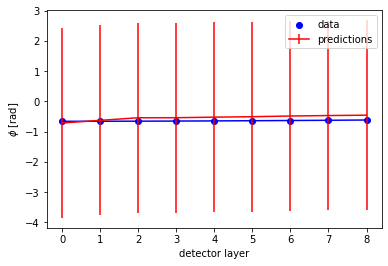

In [67]:
hitNum = 10

plt.scatter(np.arange(targets.shape[1]), targets[hitNum,:,0], label='data', color='blue')
plt.plot(np.arange(targets.shape[1]), targets[hitNum,:,0], color='blue')

#plt.scatter(np.arange(predictions.shape[1]), predictions[hitNum,:,0].detach().cpu(), label='filter', color='red')
plt.errorbar(np.arange(predictions.shape[1]), predictions[hitNum,:,0], 
              yerr=phiErr[hitNum], label='predictions', color='red')
#plt.plot(np.arange(predictions.shape[1]), predictions[hitNum,:,0].detach().cpu(), color='red')

plt.xlabel('detector layer')
plt.ylabel(r'$\phi$ [rad]')
plt.legend()
#plt.ylim(, .8)

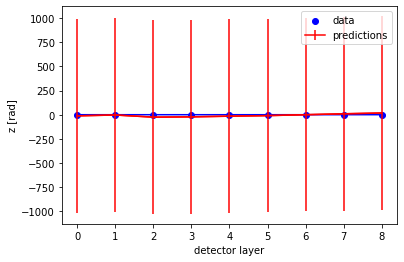

In [68]:
plt.scatter(np.arange(test_target.shape[1]), test_target[hitNum,:,1], label='data', color='blue')
plt.plot(np.arange(test_target.shape[1]), test_target[hitNum,:,1], color='blue')


#plt.scatter(np.arange(predictions.shape[1]), predictions[hitNum,:,1].detach().cpu(), label='filter', color='red')
plt.errorbar(np.arange(predictions.shape[1]), predictions[hitNum,:,1], 
             yerr=zErr[hitNum], label='predictions', color='red')
plt.plot(np.arange(predictions.shape[1]), predictions[hitNum,:,1], color='red')

plt.xlabel('detector layer')
plt.ylabel('z [rad]')
plt.legend()
#plt.ylim(0, 1000)

In [ ]:
def residuals(data, predictions):
    res = data-predictions
    res = res.flatten()
    return res

In [ ]:
#phi_res = residuals(targets[:,0,0].cpu(), predictions[:,0,0].detach().cpu())
#phi_res = phi_res[np.where((phi_res < .1) & (phi_res > -.1))[0]]
for i in range(0,8,3):
    phi_res = residuals(test_target[:,i,0], predictions[:,i,0])
    res=[]
    for phi in phi_res:
        if phi > np.pi: phi=2*np.pi-phi
        elif phi < -np.pi: phi = phi+2*np.pi
        res.append(phi)
    res = np.array(res)
    plt.hist(np.array(res), bins=50, histtype='step', label='layer {}'.format(i));
#plt.xlim([-.5, .5])
plt.yscale('log')
plt.legend()
plt.xlabel(r'$(\phi_{true} - \phi_{pred})$')

In [ ]:
for i in range(0,8,3):
    z_res = residuals(test_target[:,i,1], predictions[:,i,1])
    plt.hist(z_res, bins=30, histtype='step', label='layer {}'.format(i));
#plt.xlim([-.5, .5])
plt.yscale('log')
plt.legend()
plt.xlabel(r'$(z_{true} - z_{pred})/\sigma_{z}$')

In [ ]:
inp = tf.Variable([[1,1],[2,2],[3,3]], dtype='float')
inp = tf.reshape(inp, (1,3,2,1))
targets = inp+.1
covs = tf.eye(2, batch_shape=[1,3],dtype='float')
outputs = (inp, covs)
#gaus_llh_loss(outputs,targets )

In [162]:
model = GaussianRNN(3)
inputs = tf.Variable([[1,1,1],[2,2,2],[3,3,3]], dtype='float')
outputs = model(tf.reshape(inputs, (1,3,3)))
targets = outputs[0]+0.1

In [ ]:
gaus_llh_loss(outputs, targets)

In [164]:
targets = tf.reshape(targets, (targets.shape[0]*targets.shape[1], targets.shape[2]))

In [167]:
means = outputs[0]
means=tf.reshape(means,(means.shape[0]*means.shape[1], means.shape[2]))
covs = outputs[1]
# Calculate the inverses of the covariance matrices
inv_covs = tf.linalg.inv(covs)
# Calculate the residual error
res = targets - means
#res = tf.reshape(res, (1,3,2,1))
# Calculate the residual error term
res_right = tf.matmul(inv_covs, res)
res_term = tf.matmul(tf.transpose(res,perm=(0,2,1)), res_right)
diag_chols = tf.linalg.diag_part(tf.linalg.cholesky(covs))
log_det = tf.reduce_sum(diag_chols, axis=2)
log_det = tf.math.log(log_det)*2
gllh_loss = (tf.reshape(res_term, (1,3)) + log_det)
gllh_loss = tf.reduce_sum(gllh_loss, axis=-1)

InvalidArgumentError: Matrix size-incompatible: In[0]: [1,3,2,2], In[1]: [3,2] [Op:BatchMatMulV2]

In [168]:
res_right

<tf.Tensor: shape=(1, 3, 2, 1), dtype=float32, numpy=
array([[[[0.1049097 ],
         [0.09966367]],

        [[0.1132513 ],
         [0.10027757]],

        [[0.12170206],
         [0.10134877]]]], dtype=float32)>

In [ ]:
inv_covs

In [145]:
mean = tf.constant([[.1,10], [.6,20],[.3,30],[-.1,-15],[-.2,25],[-.3,3]], dtype='double')
mean = tf.reshape(mean, (2,3,2)) #batch size 2, 3 hits, 2 features
targets = mean+.1
var = mean / 2
correlations = tf.reshape(tf.constant([-.5,-5,-.2,-.3,-.1,-.9,], dtype='double'),(2,3,1,1))
identity = tf.eye(2, batch_shape=[2,3],dtype='double')
corr_matrix = tf.cast(tf.math.equal(identity,0), tf.float64) * correlations
corr_matrix = identity+corr_matrix
var = tf.math.exp(var)
var = tf.math.sqrt(var)
covs = tf.matmul(var[:, :,:,None], var[:,:, None, :])
covs_final = covs * corr_matrix


In [146]:
1.21824940e+01**2

148.413160060036

In [147]:
var

<tf.Tensor: shape=(2, 3, 2), dtype=float64, numpy=
array([[[1.02531512e+00, 1.21824940e+01],
        [1.16183424e+00, 1.48413159e+02],
        [1.07788415e+00, 1.80804241e+03]],

       [[9.75309912e-01, 2.35177459e-02],
        [9.51229425e-01, 5.18012825e+02],
        [9.27743486e-01, 2.11700002e+00]]])>

In [148]:
covs

<tf.Tensor: shape=(2, 3, 2, 2), dtype=float64, numpy=
array([[[[1.05127110e+00, 1.24908953e+01],
         [1.24908953e+01, 1.48413159e+02]],

        [[1.34985881e+00, 1.72431490e+02],
         [1.72431490e+02, 2.20264658e+04]],

        [[1.16183424e+00, 1.94886026e+03],
         [1.94886026e+03, 3.26901737e+06]]],


       [[[9.51229425e-01, 2.29370906e-02],
         [2.29370906e-02, 5.53084370e-04]],

        [[9.04837418e-01, 4.92749041e+02],
         [4.92749041e+02, 2.68337287e+05]],

        [[8.60707976e-01, 1.96403298e+00],
         [1.96403298e+00, 4.48168907e+00]]]])>

In [124]:
mean = tf.constant([[.1,10], [.2,20],[.3,30],[-.1,-15],[-.2,25],[-.3,3]], dtype='double')
mean = tf.reshape(mean, (6,2)) #batch size 2, 3 hits, 2 features
targets = mean+.1
var = mean / 2
correlations = tf.reshape(tf.constant([-.5,-.5,-.2,-.3,-.1,-.9,], dtype='double'),(6,1,1))
identity = tf.eye(2, batch_shape=[6],dtype='double')
corr_matrix = tf.cast(tf.math.equal(identity,0), tf.float64) * correlations
corr_matrix = identity+corr_matrix
var = tf.math.exp(var)
var = tf.math.sqrt(var)
covs = tf.matmul(var[:, :,None], var[:, None, :])
covs_final = covs * corr_matrix


In [129]:
var

<tf.Tensor: shape=(6, 2), dtype=float64, numpy=
array([[1.02531512e+00, 1.21824940e+01],
       [1.05127110e+00, 1.48413159e+02],
       [1.07788415e+00, 1.80804241e+03],
       [9.75309912e-01, 2.35177459e-02],
       [9.51229425e-01, 5.18012825e+02],
       [9.27743486e-01, 2.11700002e+00]])>

In [132]:
var

<tf.Tensor: shape=(6, 2), dtype=float64, numpy=
array([[1.02531512e+00, 1.21824940e+01],
       [1.05127110e+00, 1.48413159e+02],
       [1.07788415e+00, 1.80804241e+03],
       [9.75309912e-01, 2.35177459e-02],
       [9.51229425e-01, 5.18012825e+02],
       [9.27743486e-01, 2.11700002e+00]])>

In [131]:
tf.matmul(var[:,:,None], var[:,None,:])

<tf.Tensor: shape=(6, 2, 2), dtype=float64, numpy=
array([[[1.05127110e+00, 1.24908953e+01],
        [1.24908953e+01, 1.48413159e+02]],

       [[1.10517092e+00, 1.56022464e+02],
        [1.56022464e+02, 2.20264658e+04]],

       [[1.16183424e+00, 1.94886026e+03],
        [1.94886026e+03, 3.26901737e+06]],

       [[9.51229425e-01, 2.29370906e-02],
        [2.29370906e-02, 5.53084370e-04]],

       [[9.04837418e-01, 4.92749041e+02],
        [4.92749041e+02, 2.68337287e+05]],

       [[8.60707976e-01, 1.96403298e+00],
        [1.96403298e+00, 4.48168907e+00]]])>

In [135]:
1.02531512*1.21824940e01

12.49089529750928